In [150]:

from RBF_exosceleton.obj_io import *
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize
from sortedcontainers import SortedDict

# get_ipython().run_line_magic('matplotlib', 'widget')
plt.style.use('dark_background')
#plt.style.use('seaborn-v0_8-poster')

In [151]:
DEFORMATION_INPUT = './RBF_exosceleton/bunny_decimated.obj'
#DEFORMATION_INPUT = 'tetr_1.obj'
DEFORMATION_BASIS_FROM = './RBF_exosceleton/bunny_decimated.obj'
DEFORMATION_BASIS_TO = './RBF_exosceleton/bunny_decimated_rotated_z_10.obj'

In [152]:
f = open(DEFORMATION_INPUT, 'r')
di = f.read()
f.close()
di_vs = vertexes(di)
di_ts = triangles(di)

f = open(DEFORMATION_BASIS_FROM, 'r')
dbf = f.read()
f.close()
dbf_vs = vertexes(dbf)
dbf_ts = triangles(dbf)

f = open(DEFORMATION_BASIS_TO, 'r')
dbt = f.read()
f.close()
dbt_vs = vertexes(dbt)
dbt_ts = triangles(dbt)

print('low-polygonal models:\n\tdeformation basis from has', len(dbf_ts), 'triangles and \n\tdeformation basis to has', len(dbt_ts), 'triangles.\n')

def get_triangle_point(vertexes, triangleIndx):
    return np.array([vertexes[triangleIndx - 1][0],
                    vertexes[triangleIndx - 1][1],
                    vertexes[triangleIndx - 1][2]])


low-polygonal models:
	deformation basis from has 112 triangles and 
	deformation basis to has 112 triangles.



In [153]:
# print("di_vertexes", di_vs)
# print("di_triangles", di_ts)
# for tri, i in zip(di_ts, range(0, len(di_ts))):
#     #to_point_str = lambda tri, i: f"[{di_vs[tri[i] - 1][0]}, {di_vs[tri[i] - 1][1]}, {di_vs[tri[i] - 1][2]}]"
#     print(f"Triangle {i}: {tri} :: [{get_triangle_point(di_vs, tri[0])}, {get_triangle_point(di_vs, tri[1])}, {get_triangle_point(di_vs, tri[2])}]")

Plain equestion:
\begin{vmatrix}
x - x_1 & y - y_1 & z - z_1 \\
x_2 - x_1 & y_2 - y_1 & z_2 - z_1 \\
x_3 - x_1 & y_3 - y_1 & z_3 - z_1
\end{vmatrix} = 0

---
https://brilliant.org/wiki/3d-coordinate-geometry-equation-of-a-plane/
```math
point\ P = (x_1, y_1, z_1) \\
\vec{n} = (a, b, c)\\
a(x - x_1) + b(y - y_1) + c(z - z_1) = 0 \\
---------------- \\
Ax + Bx + Cz + D = 0 \\
D = -(Ax_0 + By_0 + Cz_0)
```
https://stackoverflow.com/questions/36060933/plot-a-plane-and-points-in-3d-simultaneously
```math
z = (\vec{a}*\vec{n} - Ax - By) / C
```


A,B,C we can find:

```math
A = (y_2 - y_1)(z_3 - z_1) - (z_2 - z_1)(y_3 - y_1) \\
B = (z_2 - z_1)(x_3 - x_1) - (x_2 - x_1)(z_3 - z_1) \\
C = (x_2 - x_1)(y_3 - y_1) - (y_2 - y_1)(x_3 - x_1)
```

In [154]:
class Plane:
	_nan_p = np.array([np.nan, np.nan, np.nan])

	id = -1

	A, B, C, D = np.nan, np.nan, np.nan, np.nan
	P1, P2, P3 = _nan_p, _nan_p, _nan_p

	@staticmethod
	def from_abcd(id, a, b, c, d):
		p = Plane()
		p.id = id
		p.A, p.B, p.C, p.D = a, b, c, d
		return p

	def __init__(self, id = -1, p1 = _nan_p, p2 = _nan_p, p3 = _nan_p):
		if np.any(np.isnan(p1)) or np.any(np.isnan(p2)) or np.any(np.isnan(p3)):
			return

		self.id = id
		self.P1, self.P2, self.P3 = p1, p2, p3

		# Calculate two vectors in the plane
		p2p1 = p2 - p1
		p3p1 = p3 - p1

		# Calculate the normal vector to the plane using the cross product
		normal_vector = np.cross(p2p1, p3p1)
		
		# Get plane coefficients
		self.A, self.B, self.C = normal_vector

		# Calculate the value of D for the plane equation ax + by + cz + d = 0
		self.D = -(self.A * p1[0] + self.B * p1[1] + self.C * p1[2])

	def __repr__(self):
		return f"Plane(id={id}; A={self.A}; B={self.B}; C={self.C}; D={self.D})"

	def __str__(self):
		return __repr__(self) # type: ignore

	def get_surface_for_z(self, X, Y): # X, Y: 2D arrays (2D grid)
		return (-self.A * X - self.B * Y - self.D) / self.C
 
	def length(self):
		# magnitude of the normal vector
		return math.sqrt(self.A ** 2 + self.B ** 2 + self.C ** 2)

	def normalized(self):
		magnitude = self.length()
		if magnitude == 0:
			return self
		else:
			return Plane.from_abcd(self.id, self.A / magnitude, self.B / magnitude, self.C / magnitude, self.D / magnitude)

	def sign_distance(self, point):
		A, B, C, D = self.A, self.B, self.C, self.D
		x, y, z = point
		return (A * x + B * y + C * z + D) / self.length()

	def distance(self, point):
		A, B, C, D = self.A, self.B, self.C, self.D
		x, y, z = point
		return (A * x + B * y + C * z + D) ** 2 / self.length()

In [155]:
import collections

Vertex = collections.namedtuple('Vertex', ['x', 'y', 'z'])
to_vertex = lambda arr: Vertex(arr[0], arr[1], arr[2])

planes: list[Plane] = []
planes_for_vertex_dict: dict[Vertex, set[Plane]] = dict()

def append_vertext_as_planes(point: list, plane: Plane):
	vertex_key = to_vertex(point)
	if vertex_key not in planes_for_vertex_dict:
		planes_for_vertex_dict[vertex_key] = set()
	planes_for_vertex_dict[vertex_key].add(plane)

for tri, id in zip(di_ts, range(0, len(di_ts))):
	p1 = get_triangle_point(di_vs, tri[0])
	p2 = get_triangle_point(di_vs, tri[1])
	p3 = get_triangle_point(di_vs, tri[2])
	plane = Plane(id, p1, p2, p3)
	planes.append(plane)

	append_vertext_as_planes(p1, plane)
	append_vertext_as_planes(p2, plane)
	append_vertext_as_planes(p3, plane)

# for i in range(10):
# 	print(f"Count of planes for Vertex {i}:", len(planes_for_vertex_dict[list(planes_for_vertex_dict.keys())[i]]))

In [156]:
%%html
<style>
/*overwrite hard coded write background by vscode for ipywidges */
.cell-output-ipywidget-background {
   background-color: transparent !important;
}

/*set widget foreground text and color of interactive widget to vs dark theme color */
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}
</style>

In [157]:
def show_orig_planes(planes: list[Plane]):
    # Define a list of colors to cycle through for each plane
	colors = ['cyan', 'magenta', 'yellow', 'blue', 'orange', 'purple', 'green']

	print("planes:", len(planes))

	# Plotting
	fig = plt.figure()
	ax = fig.add_subplot(111, projection='3d')

	######################################################
	# Collect all points to determine the maximum range across axes
	all_points = []
	for plane in planes:
		all_points.extend([plane.P1, plane.P2, plane.P3])

	all_points = np.array(all_points)
	max_range = np.array([all_points[:, 0].max() - all_points[:, 0].min(),
						all_points[:, 1].max() - all_points[:, 1].min(),
						all_points[:, 2].max() - all_points[:, 2].min()]).max() / 2.0

	mid_x = (all_points[:, 0].max() + all_points[:, 0].min()) * 0.5
	mid_y = (all_points[:, 1].max() + all_points[:, 1].min()) * 0.5
	mid_z = (all_points[:, 2].max() + all_points[:, 2].min()) * 0.5

	# Set equal scaling for the axes
	ax.set_xlim(mid_x - max_range, mid_x + max_range)
	ax.set_ylim(mid_y - max_range, mid_y + max_range)
	ax.set_zlim(mid_z - max_range, mid_z + max_range)
	######################################################

	for idx, plane in enumerate(planes):
		if (plane.C == 0 and plane.B == 0) and plane.A != 0:
			x_value = -plane.D / plane.A  # x is constant
			y_range = np.linspace(mid_y - max_range, mid_y + max_range, 10)
			z_range = np.linspace(mid_z - max_range, mid_z + max_range, 10)
			Y, Z = np.meshgrid(y_range, z_range)
			X = np.full(Y.shape, x_value)  # Set X to the constant value

		elif plane.C == 0 and plane.B != 0:
			# Define Z range instead and solve for Y
			x_range = np.linspace(min(plane.P1[0], plane.P2[0], plane.P3[0]) - 1, max(plane.P1[0], plane.P2[0], plane.P3[0]) + 1, 10)
			z_range = np.linspace(min(plane.P1[2], plane.P2[2], plane.P3[2]) - 1, max(plane.P1[2], plane.P2[2], plane.P3[2]) + 1, 10)
			X, Z = np.meshgrid(x_range, z_range)
			Y = (-plane.A * X - plane.C * Z - plane.D) / plane.B

		else:
			x_range = np.linspace(min(plane.P1[0], plane.P2[0], plane.P3[0]) - 1, max(plane.P1[0], plane.P2[0], plane.P3[0]) + 1, 10)
			y_range = np.linspace(min(plane.P1[1], plane.P2[1], plane.P3[1]) - 1, max(plane.P1[1], plane.P2[1], plane.P3[1]) + 1, 10)
			X, Y = np.meshgrid(x_range, y_range)
			Z = (-plane.A * X - plane.B * Y - plane.D) / plane.C

		color = colors[idx % len(colors)]
		ax.plot_surface(X, Y, Z, color=color, alpha=0.5, rstride=100, cstride=100, label=f"Plane {idx+1}")

		ax.scatter(*plane.P1, color='red', s=50, label="P1")
		ax.scatter(*plane.P2, color='green', s=50, label="P2")
		ax.scatter(*plane.P3, color='blue', s=50, label="P3")

	# Rotate the plot by 90 degrees (adjust as needed)
	ax.view_init(elev=30, azim=-110, roll=0)

	ax.set_xlabel('X')
	ax.set_ylabel('Y')
	ax.set_zlabel('Z')
	#ax.legend()

	plt.show()

# show_orig_planes(planes)

In [158]:
def get_polypoint_plane(plane: Plane, orig_basises: list, res_basises: list):
	a1, b1, c1, d1, r1 = 0, 0, 0, 0, 0
	a2, b2, c2, d2, r2 = 0, 0, 0, 0, 0
	a3, b3, c3, d3, r3 = 0, 0, 0, 0, 0
	a4, b4, c4, d4, r4 = 0, 0, 0, 0, 0

	for orig_basis_p, res_basis_p in zip(orig_basises, res_basises):
		orig_basis_p = np.array(orig_basis_p)
		res_basis_p = np.array(res_basis_p)

		γ = plane.sign_distance(orig_basis_p)
		# print("orig_basis_p", orig_basis_p, "\t γ", γ)

		x = res_basis_p[0]
		y = res_basis_p[1]
		z = res_basis_p[2]
		h = 1 # ???

		a1 += x * x
		b1 += x * y
		c1 += x * z
		d1 += x * h
		r1 += x * γ

		a2 += y * x
		b2 += y * y
		c2 += y * z
		d2 += y * h
		r2 += y * γ

		a3 += z * x
		b3 += z * y
		c3 += z * z
		d3 += z * h
		r3 += z * γ

		a4 += h * x
		b4 += h * y
		c4 += h * z
		d4 += h * h
		r4 += h * γ

	# Add a small regularization term to the diagonal elements of A
	reg_term = 1e-16
	A = np.array([
		[a1 + reg_term, b1, c1, d1],
		[b1, b2 + reg_term, c2, d2],
		[c1, c2, c3 + reg_term, d3],
		[d1, d2, d3, d4 + reg_term]])

	B = np.array([r1, r2, r3, r4])
	X = np.linalg.solve(A, B)
	return Plane.from_abcd(plane.id, X[0], X[1], X[2], X[3])


def get_polypoint_planes_dict(in_planes: list[Plane], orig_basises: list, res_basises: list) -> SortedDict[int, Plane]:
	result_planes: SortedDict[int, Plane] = SortedDict() # id, Plane
	for plane in in_planes:
		tr_plane = get_polypoint_plane(plane, orig_basises, res_basises).normalized()
		assert tr_plane.id != -1
		result_planes[tr_plane.id] = tr_plane
	return result_planes

In [159]:
def closest_point_to_planes_min(planes: list[Plane]) -> np.array:
	def objective_function(point: list, planes: list[Plane]):
		# The sum of squared distances to the planes
		return sum(plane.distance(point) for plane in planes)

	# Initial point (zero point) for the minimizer
	initial_point = (0, 0, 0)

	min_result = minimize(objective_function, initial_point, args=(planes,), method='L-BFGS-B', options={'iprint': 99})
	return min_result.x # closest_point

def closest_point_to_planes_lstsq(planes: list[Plane]):
	A = np.array([[plane.A, plane.B, plane.C] for plane in planes])
	B = np.array([-plane.D for plane in planes])
	X = np.linalg.lstsq(A, B, rcond=None)[0]
	return X

def closest_point_to_planes_pinv(planes: list[Plane]):
	A = np.array([[plane.A, plane.B, plane.C] for plane in planes])
	B = np.array([-plane.D for plane in planes])
	# Compute the pseudo-inverse of A
	A_pinv = np.linalg.pinv(A)
	# Get the least-squares solution to the A system
	return A_pinv.dot(B)

In [160]:
# show_planes

# Define a list of colors to cycle through for each plane
colors = ['cyan', 'magenta', 'yellow', 'blue', 'orange', 'purple', 'green']
closest_point_methods = ['min', 'lstsq', 'pinv']

def show_planes(planes: list[Plane]):

	# print("planes:", len(planes))

	# Plotting
	fig = plt.figure(figsize=(6, 6), dpi=80)
	ax: Axes3D = fig.add_subplot(111, projection='3d')

	min_x = -100
	max_x = 100
	x_range = np.linspace(min_x, max_x, 10)
	y_range = np.linspace(min_x, max_x, 10)
	z_range = np.linspace(min_x, max_x, 10)

	for idx, plane in enumerate(planes):
		if (plane.C == 0 and plane.B == 0) and plane.A != 0:
			x_value = -plane.D / plane.A  # x is constant
			Y, Z = np.meshgrid(y_range, z_range)
			X = np.full(Y.shape, x_value)  # Set X to the constant value

		elif plane.C == 0 and plane.B != 0:
			# Define Z range instead and solve for Y
			X, Z = np.meshgrid(x_range, z_range)
			Y = (-plane.A * X - plane.C * Z - plane.D) / plane.B

		else:
			X, Y = np.meshgrid(x_range, y_range)
			Z = (-plane.A * X - plane.B * Y - plane.D) / plane.C

		color = colors[idx % len(colors)]
		ax.plot_surface(X, Y, Z, color=color, alpha=0.5, rstride=100, cstride=100, label=f"Plane {idx+1}")

	# Draw Closest Point to the Planes using different methods
	for idx, closest_point in enumerate([closest_point_to_planes_min(planes),
								 	closest_point_to_planes_lstsq(planes),
									closest_point_to_planes_pinv(planes)]):
		closest_point = [ round(elem, 2) for elem in closest_point ]
		color = colors[idx % len(colors) + 1]
		method_name = closest_point_methods[idx]
		ax.scatter(*closest_point, color=color, s=50,
			 label=f"Closest point ({method_name}) [{closest_point[0]}, {closest_point[1]}, {closest_point[2]}]")

	# Rotate the plot by 90 degrees (adjust as needed)
	ax.view_init(elev=30, azim=-110, roll=0)

	ax.set_xlabel('X')
	ax.set_ylabel('Y')
	ax.set_zlabel('Z')
	#ax.legend()

	plt.show()

def show_vertexes(vertexes: list[np.array]):
	fig = plt.figure(figsize=(6, 6), dpi=80)
	ax: Axes3D = fig.add_subplot(111, projection='3d')

	for idx, vertex in enumerate(vertexes):
		color = colors[idx % len(colors)]
		ax.scatter(vertex[0], vertex[1], vertex[2], color=color, s=50, label=f"Vertex {idx+1}")

	# Rotate the plot by 90 degrees (adjust as needed)
	ax.view_init(elev=30, azim=-110, roll=0)

	ax.set_xlabel('X')
	ax.set_ylabel('Y')
	ax.set_zlabel('Z')
	#ax.legend()

	plt.show()

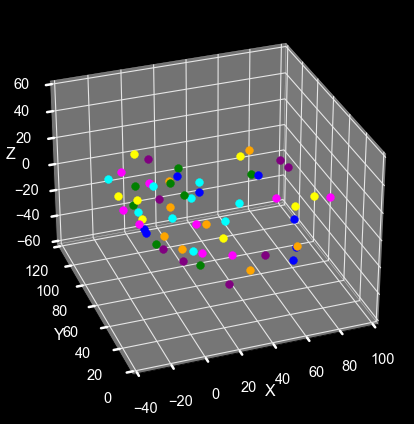

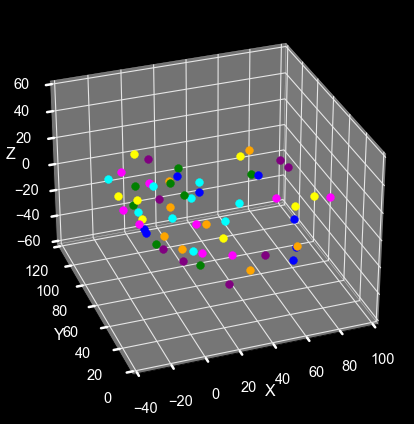

interactive(children=(FloatSlider(value=1.0, description='p1_x', max=2.0, min=1.0, step=0.001), FloatSlider(va…

In [ ]:
from ipywidgets import interact

def get_transformed_vertexes(planes_for_vertex_dict: dict[Vertex, set[Plane]], tr_planes: SortedDict[int, Plane]) -> list[np.array]:
	# Get transformed vertexes by finding closest points to transformed planes
	result_vertexes : list[np.array] = []
	for planes_for_vertex_set in planes_for_vertex_dict.values():
		tr_planes_for_vertex_set: set[Plane] = set()

		# Find all transformed planes (by Plane.id) that will later represent transformed vertex
		for plane_for_vertex in planes_for_vertex_set:
			tr_planes_for_vertex_set.add(tr_planes[plane_for_vertex.id])

		# Find vertex after transformation
		# print(len(tr_planes_for_vertex_set))
		result_vertexes.append(closest_point_to_planes_pinv(tr_planes_for_vertex_set))
	return result_vertexes


def show_transformed_obj(orig_basises: list, res_basises: list):
	# Get transformed planes
	tr_planes = get_polypoint_planes_dict(planes, orig_basises, res_basises)
	tr_vertexes  = get_transformed_vertexes(planes_for_vertex_dict, tr_planes)

	# Before transformation
	show_vertexes(planes_for_vertex_dict.keys())
	# After transformation
	show_vertexes(tr_vertexes)

	# show_planes(tr_planes.values())

	with open('result_pp_deformed.obj', 'w') as f:
		f.write(str_from_vertexes(tr_vertexes) + str_from_faces(di_ts))


def on_basis_changed(p1_x = 1.0, p1_y = 0.0, p1_z = 0.0):

	orig_basises = [[1, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, -1.0], [0.0, 0.0, 1.0]]
	res_basises = [[p1_x, p1_y, p1_z], [0.0, 1.0, 0.0], [0.0, 0.0, -1.0], [0.0, 0.0, 1.0]]

	show_transformed_obj(orig_basises, res_basises)


# on_basis_changed()
interact(on_basis_changed, p1_x=(1.0, 2.0, 0.001), p1_y=(0.0,1.0, 0.001), p1_z=(0.0,1.0, 0.001));